In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

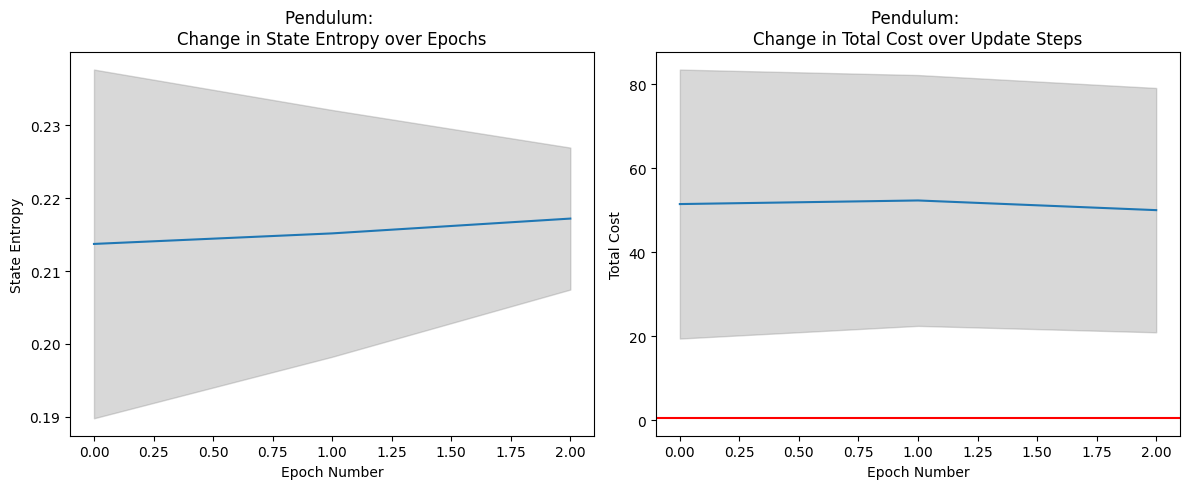

In [2]:
# df = pd.read_csv("results/MountainCarContinuous/CEM_Omega_5000/MountainCarContinuous-v0.csv", index_col = False)
df = pd.read_csv("results/Pendulum/CEM/Pendulum-v1.csv", index_col = False)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

sns.lineplot(data = df, x = "epoch", y = "mean_entropy", ax = ax[0])
ax[0].set_xlabel("Epoch Number")
ax[0].set_ylabel("State Entropy")
ax[0].fill_between(
    df["epoch"],
    df["mean_entropy"] - df["std_entropy"],
    df["mean_entropy"] + df["std_entropy"],
    color="gray",
    alpha=0.3,
)
ax[0].set_title("Pendulum: \nChange in State Entropy over Epochs")

sns.lineplot(data = df, x = "epoch", y = "mean_cost", ax = ax[1])
ax[1].set_xlabel("Epoch Number")
ax[1].set_ylabel("Total Cost")
ax[1].fill_between(
    df["epoch"],
    df["mean_cost"] - df["std_cost"],
    df["mean_cost"] + df["std_cost"],
    color="gray",
    alpha=0.3,
)
plt.axhline(y=0.5, color="red")
# plt.axhline(y=10, color="red")
ax[1].set_title("Pendulum: \nChange in Total Cost over Update Steps")

fig.tight_layout()

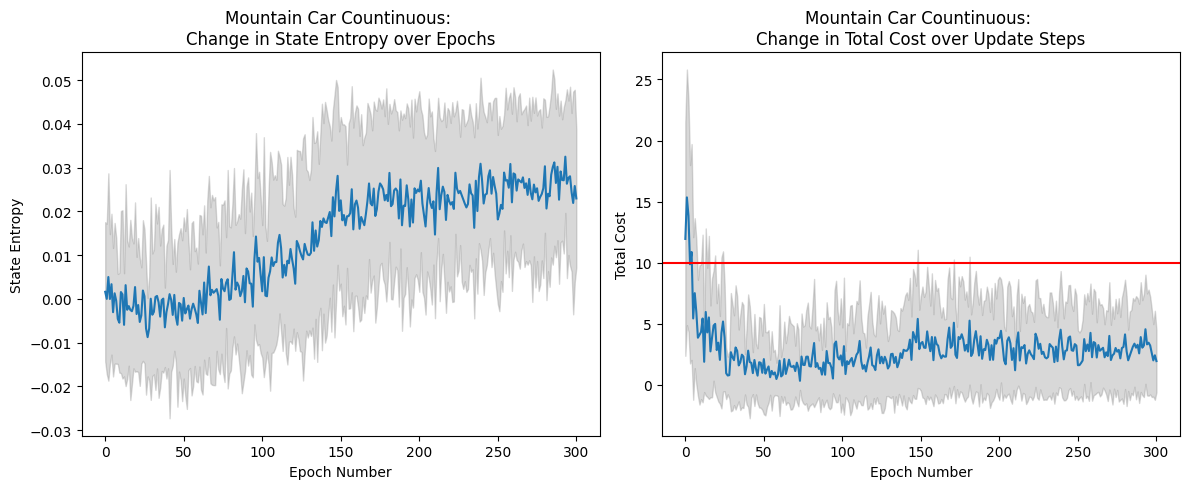

In [7]:
# df = pd.read_csv("results/MountainCarContinuous/CEM_Omega_5000/MountainCarContinuous-v0.csv", index_col = False)
df = pd.read_csv("results/MountainCarContinuous/CEM/MountainCarContinuous-v0.csv", index_col = False)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

sns.lineplot(data = df, x = "epoch", y = "mean_entropy", ax = ax[0])
ax[0].set_xlabel("Epoch Number")
ax[0].set_ylabel("State Entropy")
ax[0].fill_between(
    df["epoch"],
    df["mean_entropy"] - df["std_entropy"],
    df["mean_entropy"] + df["std_entropy"],
    color="gray",
    alpha=0.3,
)
ax[0].set_title("Mountain Car Countinuous: \nChange in State Entropy over Epochs")

sns.lineplot(data = df, x = "epoch", y = "mean_cost", ax = ax[1])
ax[1].set_xlabel("Epoch Number")
ax[1].set_ylabel("Total Cost")
ax[1].fill_between(
    df["epoch"],
    df["mean_cost"] - df["std_cost"],
    df["mean_cost"] + df["std_cost"],
    color="gray",
    alpha=0.3,
)
# plt.axhline(y=0.5, color="red")
plt.axhline(y=10, color="red")
ax[1].set_title("Mountain Car Countinuous: \nChange in Total Cost over Update Steps")

fig.tight_layout()

<Axes: xlabel='epoch', ylabel='mean_entropy'>

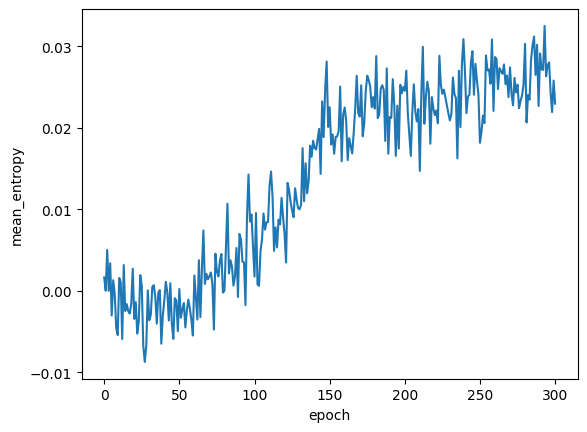

In [3]:
sns.lineplot(data=df, x="epoch", y="mean_entropy")

<Axes: xlabel='epoch', ylabel='advantage'>

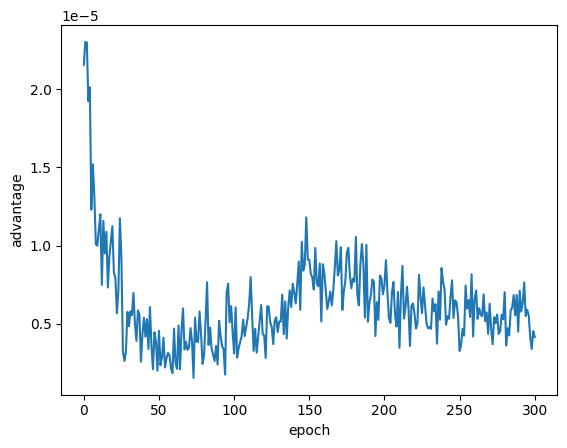

In [4]:
sns.lineplot(data=df, x="epoch", y="advantage")

<Axes: >

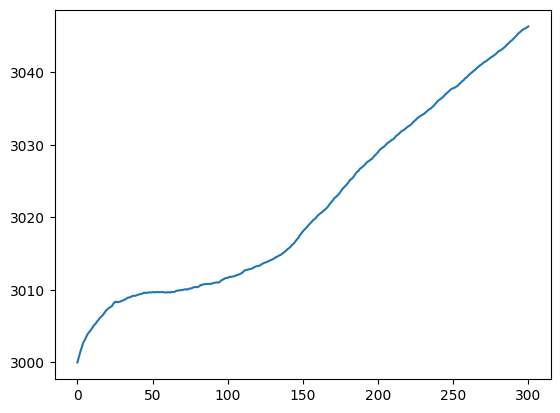

In [5]:
df["safety_weight"].plot()

<Axes: >

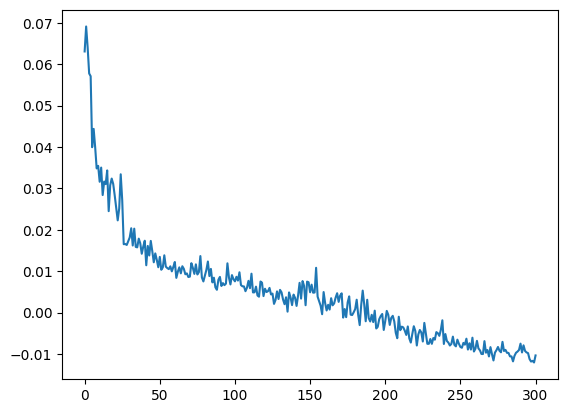

In [6]:
df["policy_loss"].plot()

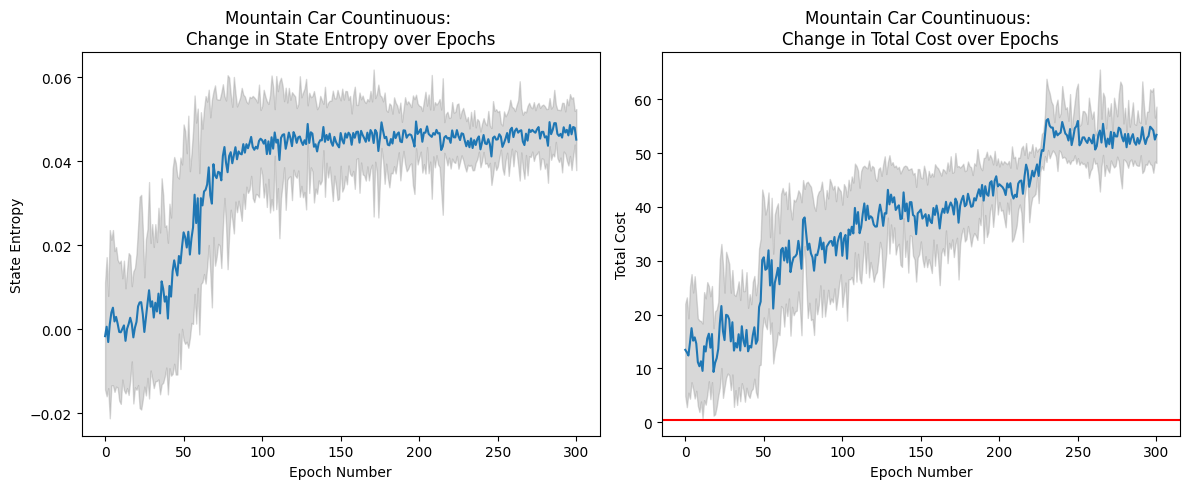

In [5]:
df = pd.read_csv("results/MountainCarContinuous/MEPOL/MountainCarContinuous-v0.csv", index_col = False)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

sns.lineplot(data = df, x = "epoch", y = "mean_entropy", ax = ax[0])
ax[0].set_xlabel("Epoch Number")
ax[0].set_ylabel("State Entropy")
ax[0].fill_between(
    df["epoch"],
    df["mean_entropy"] - df["std_entropy"],
    df["mean_entropy"] + df["std_entropy"],
    color="gray",
    alpha=0.3,
)
ax[0].set_title("Mountain Car Countinuous: \nChange in State Entropy over Epochs")

sns.lineplot(data = df, x = "epoch", y = "mean_cost", ax = ax[1])
ax[1].set_xlabel("Epoch Number")
ax[1].set_ylabel("Total Cost")
ax[1].fill_between(
    df["epoch"],
    df["mean_cost"] - df["std_cost"],
    df["mean_cost"] + df["std_cost"],
    color="gray",
    alpha=0.3,
)
plt.axhline(y=0.5, color="red")
ax[1].set_title("Mountain Car Countinuous: \nChange in Total Cost over Epochs")

fig.tight_layout()

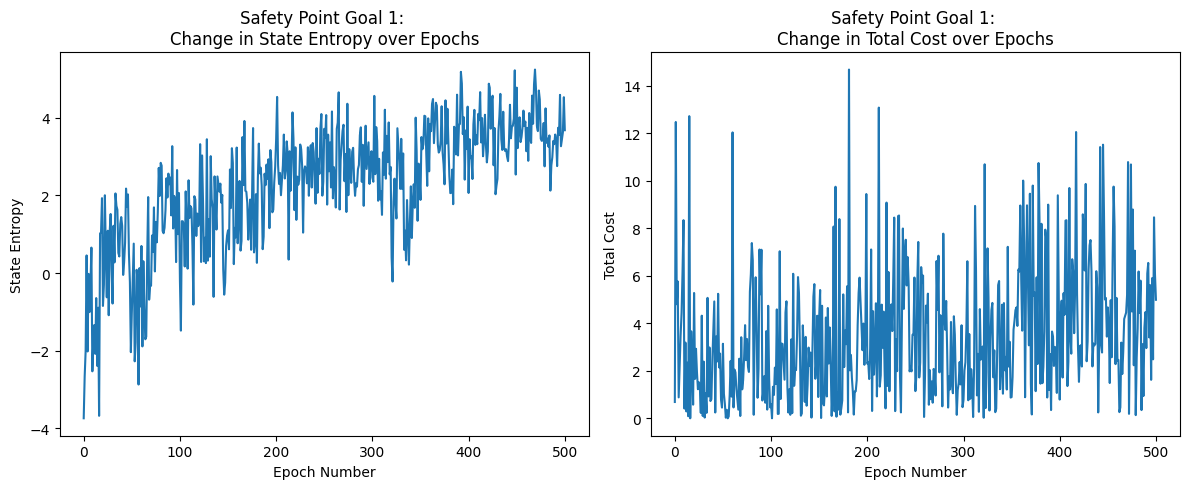

In [ ]:
df = pd.read_csv("results/SafetyPointGoal1/MEPOL/SafetyPointGoal1-v0.csv", index_col = False)
df["cost"] = abs(df["cost"])
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

sns.lineplot(data = df, x = "epoch", y = "entropy", ax = ax[0])
ax[0].set_xlabel("Epoch Number")
ax[0].set_ylabel("State Entropy")
ax[0].set_title("Safety Point Goal 1: \nChange in State Entropy over Epochs")

sns.lineplot(data = df, x = "epoch", y = "cost", ax = ax[1])
ax[1].set_xlabel("Epoch Number")
ax[1].set_ylabel("Total Cost")
ax[1].set_title("Safety Point Goal 1: \nChange in Total Cost over Epochs")

fig.tight_layout()

In [37]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

int_type = torch.int64
float_type = torch.float64
torch.set_default_dtype(float_type)

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim=2, action_dim=1, state_dependent_std=True, is_discrete=False, device="cpu"):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(state_dim, 300), nn.ReLU(),
            nn.Linear(300, 300), nn.ReLU(),
        )

        # Output of the network: Mean and log standard deviation
        self.mean_head = nn.Linear(300, action_dim)
        self.state_dependent_std = state_dependent_std
        
        if state_dependent_std:
            # std depends on state
            self.log_std_head = nn.Linear(300, action_dim)
        else:
            # single learnable parameter
            self.log_std_param = nn.Parameter(
                -0.5 * torch.ones(action_dim, dtype=float_type)
            )

        # Constant
        self.log_of_two_pi = torch.tensor(np.log(2 * np.pi), dtype = float_type)
        self.eps = 1e-7

        self.is_discrete = is_discrete
        self.device = device

        self.initialize_weights()

    def initialize_weights(self):
        nn.init.xavier_uniform_(self.mean_head.weight)
        if self.state_dependent_std:
            nn.init.xavier_uniform_(self.log_std_head.weight)

        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)

    def get_log_p(self, states, actions):
        # mean, _ = self(states)
        # if self.is_discrete:
        #     log_mean = torch.log(mean + self.eps)
        #     return log_mean.gather(1, actions).squeeze(-1)
        # else:
        #     return torch.sum(
        #         -0.5 * (
        #             self.log_of_two_pi
        #             + 2 * self.log_std
        #             + ((actions - mean) ** 2 / (torch.exp(self.log_std) + self.eps) ** 2)
        #         ), dim = 1
        #     )
        if self.is_discrete:
            logits, _ = self(states)
            log_probs = torch.log_softmax(logits, dim=-1)
            return log_probs.gather(1, actions).squeeze(-1)

        mean, log_std = self._forward_stats(states)
        std2 = torch.exp(2 * log_std)
        log_p = -0.5 * (
            self.log_of_two_pi + 2 * log_std +
            (actions - mean) ** 2 / (std2 + self.eps)
        )
        return torch.sum(log_p, dim=1)        

    def _forward_stats(self, x):
        h = self.net(x)
        mean = self.mean_head(h)

        if self.is_discrete:
            # discrete policies do not use std
            return mean, None

        if self.state_dependent_std:
            log_std = self.log_std_head(h)
            # Clamp for numerical stability
            # log_std = torch.clamp(log_std, -10.0, 2.0)
        else:
            log_std = self.log_std_param

        return mean, log_std

    def forward(self, x, deterministic=False):
        mean, log_std = self._forward_stats(x)

        if self.is_discrete:
            logits = mean
            probs = F.softmax(mean, dim=-1)
            return logits, probs

        # continuous action → sample / deterministic
        std = torch.exp(log_std)
        if deterministic:
            action = mean
        else:    
            action = mean + torch.randn_like(mean) * std

        return std, action

    def predict(self, s, deterministic=False):
        with torch.inference_mode():
            if not isinstance(s, torch.Tensor):
                s = torch.tensor(s, dtype=float_type, device=self.device)

            if s.dim() == 1:
                s = s.unsqueeze(0)

            if self.is_discrete:
                _, probs = self(s)
                if deterministic:
                    action = torch.argmax(probs, dim=-1)
                else:
                    action = torch.multinomial(probs, 1).squeeze(-1)
            else:
                _, action = self(s, deterministic=deterministic)

            return action

In [43]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def visualize_policy_comparison(model_link, num_states=1000, seed=0):
    before_model = PolicyNetwork()
    after_model = PolicyNetwork()
    before_model.load_state_dict(torch.load(f"{model_link}/0-policy.pt"))
    after_model.load_state_dict(torch.load(f"{model_link}/2-policy.pt"))    
    torch.manual_seed(seed)
    np.random.seed(seed)

    before_model.eval()
    after_model.eval()

    # Sample random states from MountainCarContinuous state space
    positions = np.random.uniform(-1.2, 0.6, num_states)
    velocities = np.random.uniform(-0.07, 0.07, num_states)
    states = np.stack([positions, velocities], axis=1)
    states_tensor = torch.tensor(states, dtype=torch.float64)

    with torch.no_grad():
        before_std, before_actions = before_model(states_tensor, deterministic=True)
        after_std, after_actions = after_model(states_tensor, deterministic=True)

    # Convert to numpy
    before_std_np = before_std.cpu().numpy()
    after_std_np = after_std.cpu().numpy()
    before_actions_np = before_actions.cpu().numpy()
    after_actions_np = after_actions.cpu().numpy()

    # Plot histograms of action samples
    plt.figure(figsize=(18, 4))

    plt.subplot(1, 2, 1)
    plt.hist(before_actions_np, bins=100, alpha=0.6, label='Before Training', density=True)
    plt.hist(after_actions_np, bins=100, alpha=0.6, label='After Training', density=True)
    plt.title("Sampled Actions (Before vs After)")
    plt.xlabel("Action")
    plt.ylabel("Density")
    plt.legend()

    plt.tight_layout()
    plt.show()


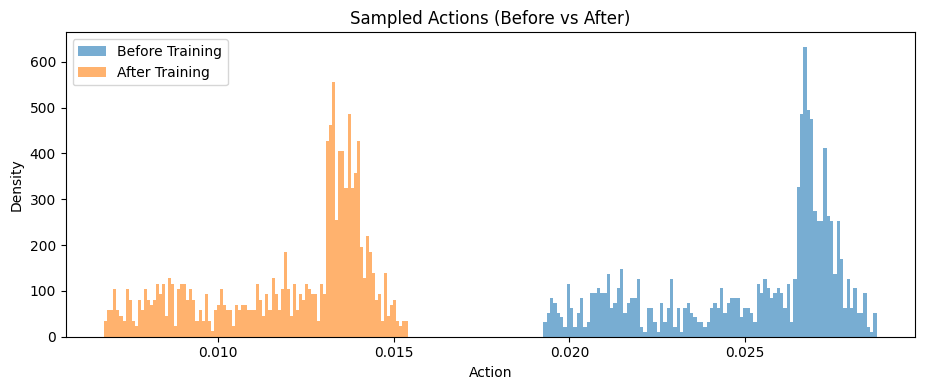

In [44]:
visualize_policy_comparison("./results/MountainCarContinuous/CEM")

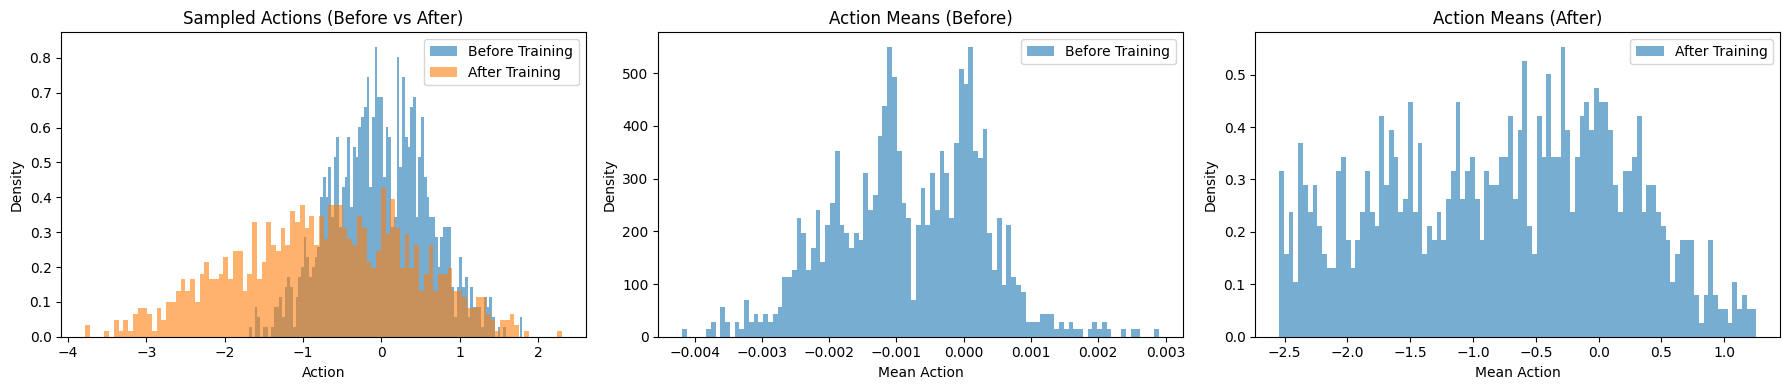

In [68]:
visualize_policy_comparison("./results/MountainCarContinuous/MEPOL")

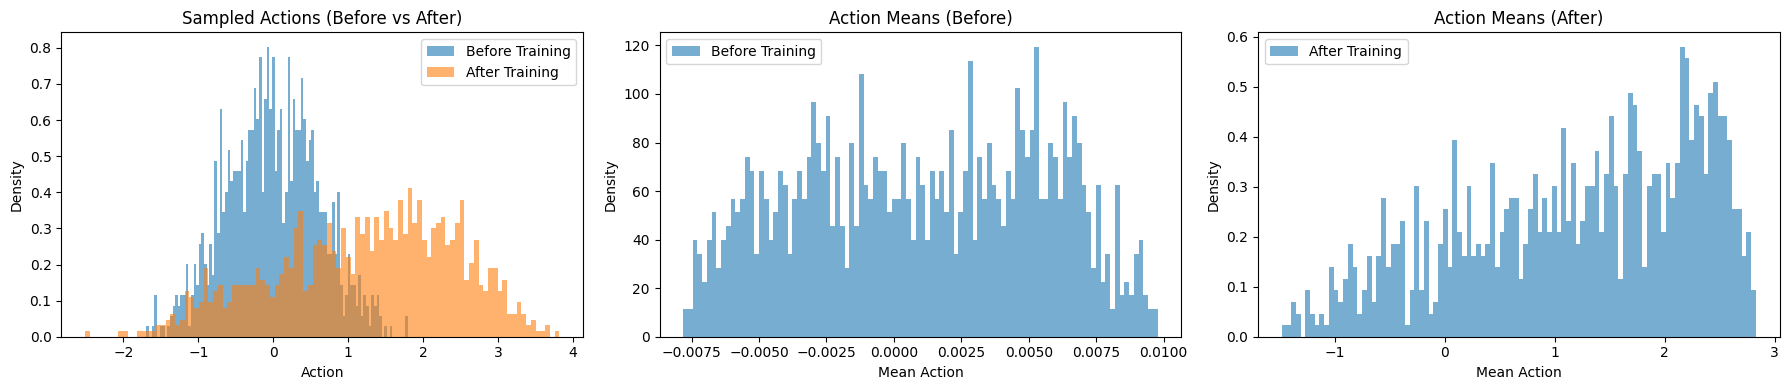

In [67]:
visualize_policy_comparison("./results/MountainCarContinuous/CEM_Omega_3000")

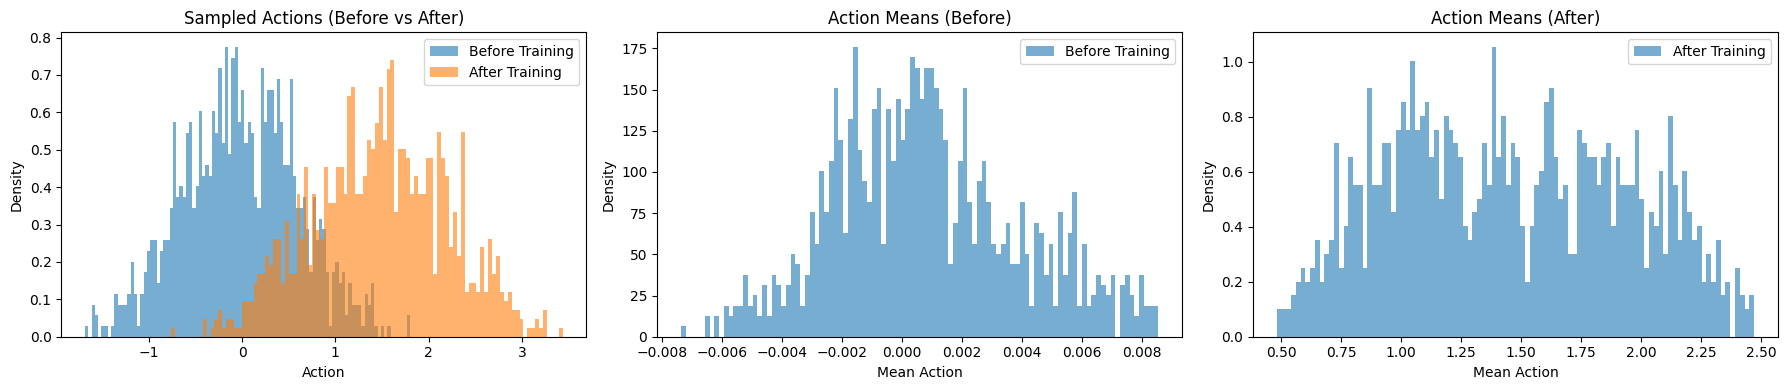

In [65]:
visualize_policy_comparison("./results/MountainCarContinuous/CEM_Omega_4000")

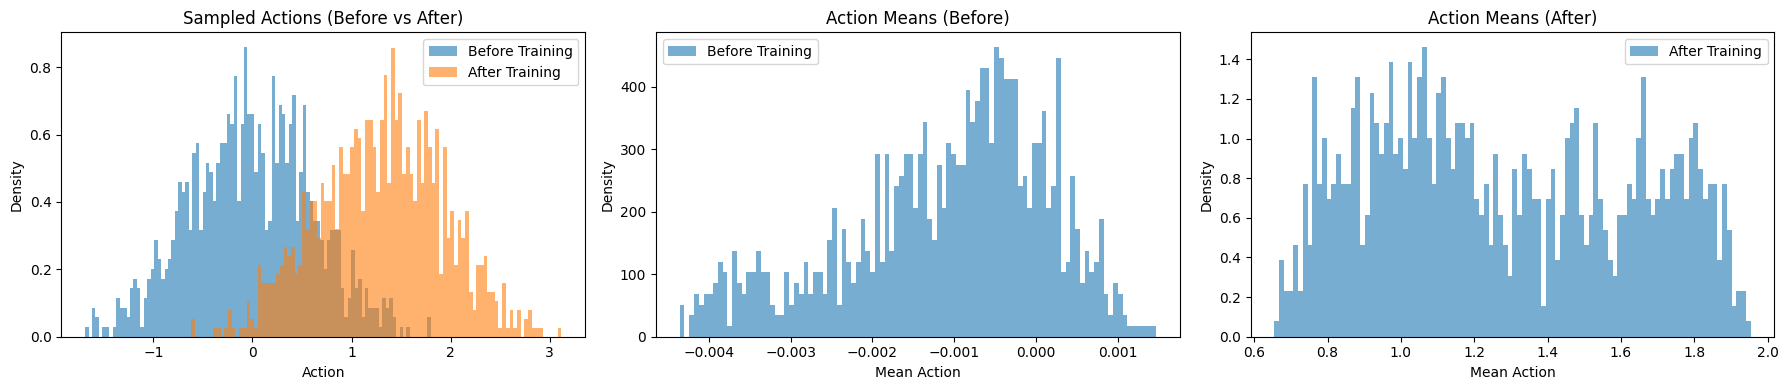

In [66]:
visualize_policy_comparison("./results/MountainCarContinuous/CEM_Omega_5000")

In [45]:
def visualize_policy_heatmap(model_link, use_mean=True, seed=0):
    before_model = PolicyNetwork()
    after_model = PolicyNetwork()
    before_model.load_state_dict(torch.load(f"{model_link}/0-policy.pt"))
    after_model.load_state_dict(torch.load(f"{model_link}/2-policy.pt"))    
    torch.manual_seed(seed)
    np.random.seed(seed)

    before_model.eval()
    after_model.eval()

    # Find some discrete states from MountainCarContinuous state space
    all_positions = np.arange(-1.2, 0.6 + 1e-8, 0.01)
    all_velocities = np.arange(-0.07, 0.07 + 1e-8, 0.001)
    grid_x, grid_y = np.meshgrid(all_positions, all_velocities)
    states = np.column_stack([grid_x.ravel(), grid_y.ravel()])
    states_tensor = torch.tensor(states, dtype=torch.float64)

    with torch.no_grad():
        before_std, before_action = before_model(states_tensor, deterministic=True)
        after_std, after_action = after_model(states_tensor, deterministic=True) 

    # Convert to 2D heatmaps
    before_action_np = before_action.cpu().numpy().reshape(grid_x.shape)
    after_action_np = after_action.cpu().numpy().reshape(grid_x.shape)
    before_std_np = before_std.cpu().numpy().reshape(grid_x.shape)
    after_std_np = after_std.cpu().numpy().reshape(grid_x.shape)    

    safety_val = -0.6

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    if use_mean:
        im1 = ax1.imshow(before_action_np, origin='lower', extent=[-1.2, 0.6, -0.07, 0.07], aspect='auto')
        ax1.set_title("Before Training: Action Mean")
    else:
        im1 = ax1.imshow(before_std_np, origin='lower', extent=[-1.2, 0.6, -0.07, 0.07], aspect='auto')   
        ax1.set_title("Before Training: Action Standard Deviation") 
    
    ax1.set_xlabel("Position")
    ax1.set_ylabel("Velocity")
    ax1.axvline(x=safety_val, color='red', linestyle='--', linewidth=2)
    fig.colorbar(im1, ax=ax1)

    if use_mean:
        im2 = ax2.imshow(after_action_np, origin='lower', extent=[-1.2, 0.6, -0.07, 0.07], aspect='auto')
        ax2.set_title("After Training: Action Mean")
    else:
        im2 = ax2.imshow(after_std_np, origin='lower', extent=[-1.2, 0.6, -0.07, 0.07], aspect='auto')   
        ax2.set_title("After Training: Action Standard Deviation") 
    ax2.set_xlabel("Position")
    ax2.set_ylabel("Velocity")
    ax2.axvline(x=safety_val, color='red', linestyle='--', linewidth=2)
    fig.colorbar(im2, ax=ax2)

    plt.tight_layout()
    plt.show()


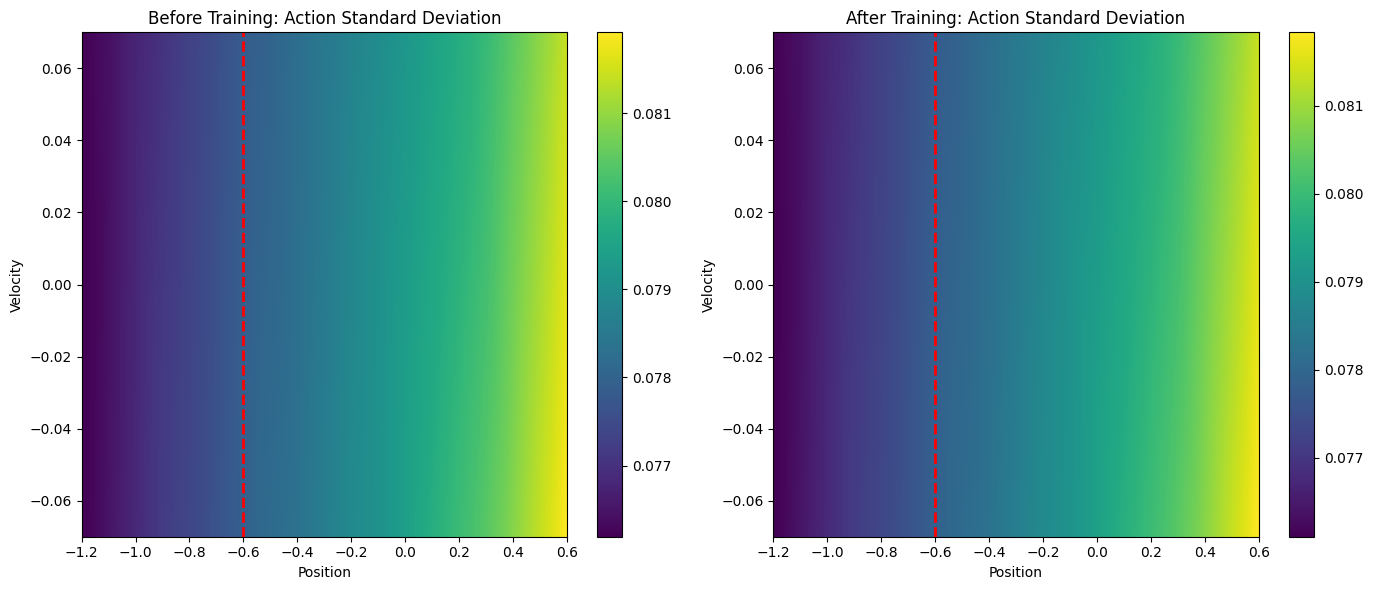

In [46]:
visualize_policy_heatmap("./results/MountainCarContinuous/CEM", False)

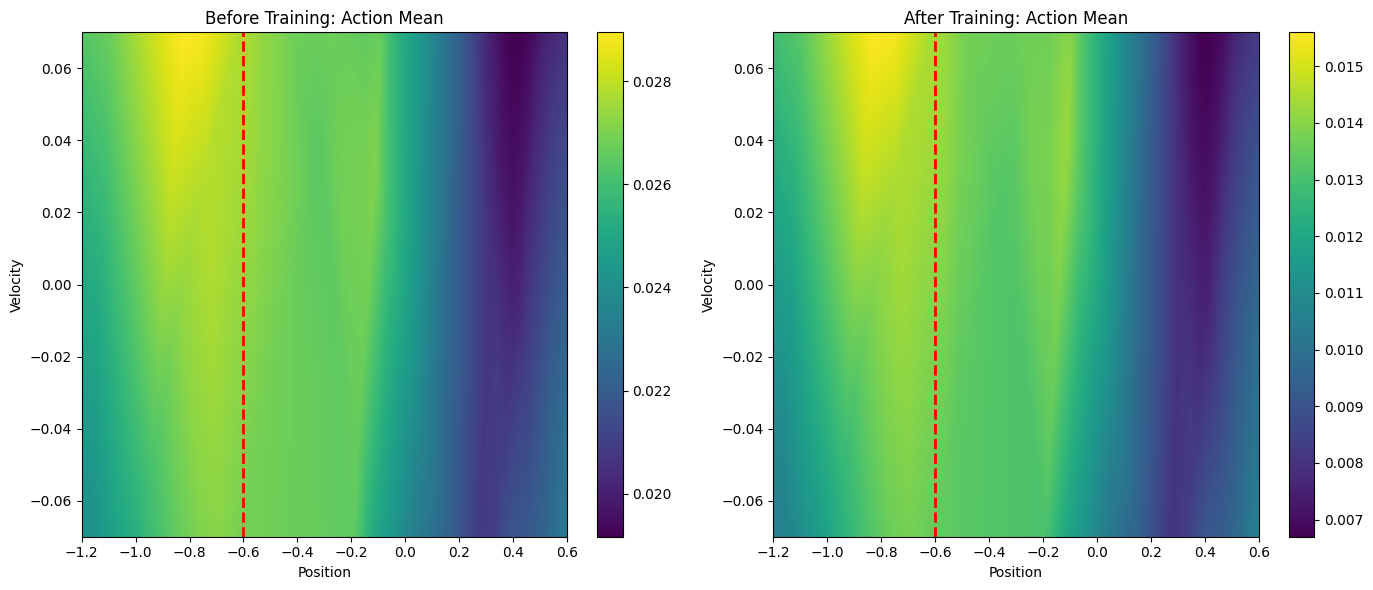

In [47]:
visualize_policy_heatmap("./results/MountainCarContinuous/CEM")